# Create pseudo-driving data-set (multi-modal version)

In [1]:
# set this to False if you want to generate training data
# set this to True if you want to visualize the expert's trajectory on the track

plot_expert_trajectory = False  

## Imports

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

## Two branches of the track as functions

In [3]:
def curvy_func_1(x):
    y = np.zeros_like(x)
    y[x < 34.5] = np.sin(x[x < 34.5])
    y[x >= 34.5] = np.log(1 + x[x >= 34.5] - 34.5) * 0.5
    return y

In [4]:
def curvy_func_2(x):
    y = np.zeros_like(x)
    y[x < 34.5] = np.sin(x[x < 34.5])
    y[x >= 34.5] = -np.log(1 + x[x >= 34.5] - 34.5) * 0.5
    return y

In [5]:
road_stepsize = 0.1
agent_stepsize = 0.5
ratio = agent_stepsize / road_stepsize
assert ratio == int(ratio)
ratio = int(ratio)

In [6]:
xs = np.arange(0, 10 * 2 * np.pi, road_stepsize)
xs_step = np.arange(0, 9 * 2 * np.pi, agent_stepsize)
ys_1 = curvy_func_1(xs)
ys_2 = curvy_func_2(xs)

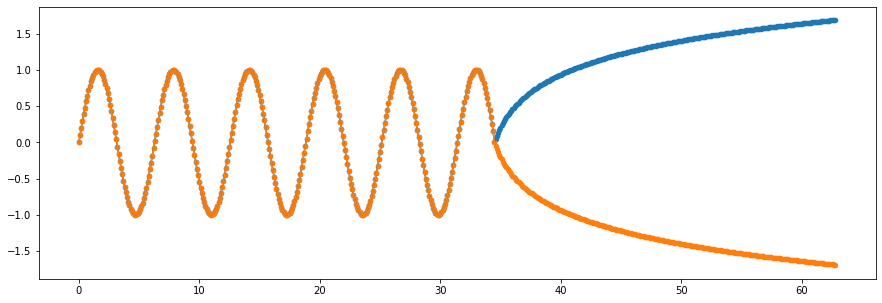

In [7]:
plt.figure(figsize=(15, 5))
plt.scatter(xs, ys_1, s=20)
plt.scatter(xs, ys_2, s=20)
plt.plot(xs, ys_1)
plt.plot(xs, ys_2)
plt.show()

## Convert functions into 2-d arrays

In [8]:
stepsize=0.05

In [9]:
y_bins = np.arange(-3, 3+stepsize, stepsize)

In [10]:
entire_traj = np.zeros((len(xs), len(y_bins)))  # stands for entire trajectory
print(entire_traj.shape)

(629, 121)


In [11]:
for i, x in enumerate(xs):
    for j in range(len(y_bins) - 1):
        if (curvy_func_1(x) >= y_bins[j] and curvy_func_1(x) < y_bins[j+1]) or \
           (curvy_func_2(x) >= y_bins[j] and curvy_func_2(x) < y_bins[j+1]):
            entire_traj[i][j-3:j+3] = 1  # the track has a width of 6 pixels

### Get expert locations


 Expert locations are the points along its trajectories in terms of rows and columns (coordinate system of the `entire_traj` array). They are generated using the two functions (`curvy_func_1` and `curvy_func_2`) that were used to generate the track.

For trajectory 1:

In [12]:
locs_1 = []

for i, x in enumerate(xs_step):
    for j in range(len(y_bins) - 1):
        
        if curvy_func_1(x) >= y_bins[j] and curvy_func_1(x) < y_bins[j+1]:
            
            if plot_expert_trajectory:
                entire_traj[i*ratio, j] = 10
            
            locs_1.append([i*ratio, j])
            break

locs_1 = np.array(locs_1)
locs_1.shape

(114, 2)

For trajectory 2:

In [13]:
locs_2 = []

for i, x in enumerate(xs_step):
    for j in range(len(y_bins) - 1):
        
        if (curvy_func_2(x) >= y_bins[j] and curvy_func_2(x) < y_bins[j+1]):
            
            if plot_expert_trajectory:
                entire_traj[i*ratio, j] = 10
            
            locs_2.append([i*ratio, j])
            break
            
locs_2 = np.array(locs_2)
locs_2.shape

(114, 2)

### Get observations using expert locations

The maximum of number of columns moved in one time-step:

In [14]:
y_step_max = np.max(locs_1[:,1][1:] - locs_1[:,1][:-1])
y_step_max

10

In [15]:
def get_obs(loc):
    x, y = loc
    return entire_traj[x:x+10, y-2*y_step_max:y+2*y_step_max]

(10, 40)


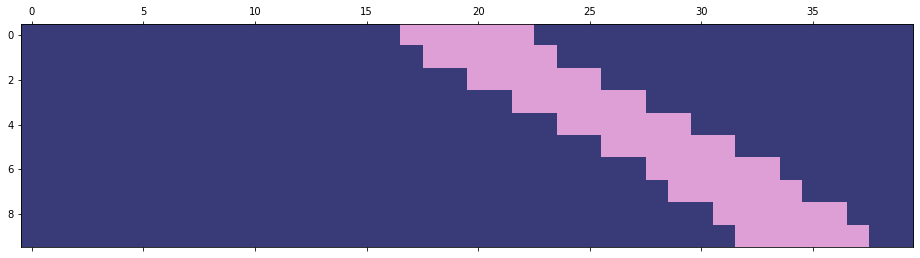

In [16]:
plt.matshow(get_obs(locs_1[0]), cmap='tab20b')
print(get_obs(locs_1[0]).shape)
plt.show()

In [17]:
observations = []
for loc in np.vstack([locs_1[:-1], locs_2[:-1]]):  # no actions available for the last states
    observations.append(get_obs(loc))
observations = np.array(observations)
print(observations.shape)

(226, 10, 40)


### Get actions using expert locations

In [18]:
actions_1 = locs_1[1:] - locs_1[:-1]
actions_2 = locs_2[1:] - locs_2[:-1]
actions = np.vstack([actions_1, actions_2])
print(actions.shape)

(226, 2)


## Quick visualization of the track (transposed)

If you want to see expert actions on this track, set the `plot_expert_trajectory` flag at the beginning of this notebook to `True`. Note that you can't ouput training data and track in the next section if you do so.

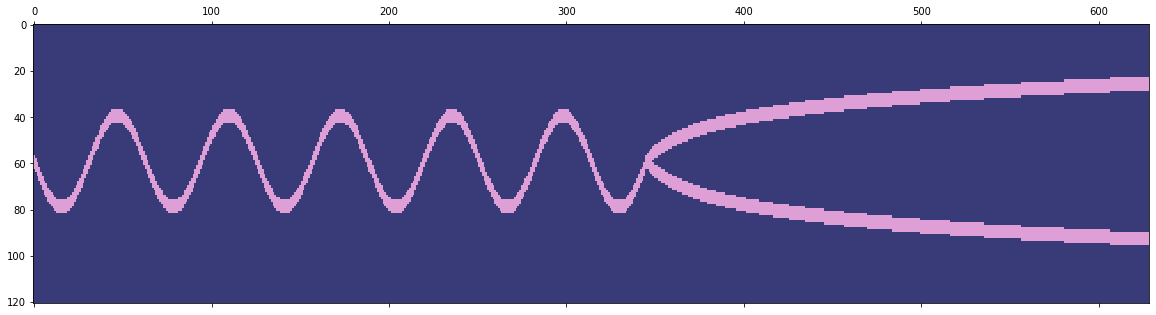

In [19]:
plt.figure(figsize=(20, 5))
plt.matshow(entire_traj.T, fignum=1, aspect='auto', cmap='tab20b')
plt.show()

## Output training data and track

In [20]:
if not plot_expert_trajectory:
    with open('../data/pseudo_driving_dataset_multimodal.json', 'w+') as json_f:
        json.dump([observations.tolist(), actions.tolist()], json_f)
    with open('../data/pseudo_driving_track_multimodal.json', 'w+') as json_f:
        json.dump(entire_traj.tolist(), json_f)
else:
    print('[Failed] Please set the plot_expert_trajectory flag to False to output training data and track.')